In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

## Simulation

### Speed and Position

Simulate an animal running back and forth on a track with pauses at the top of the track

/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


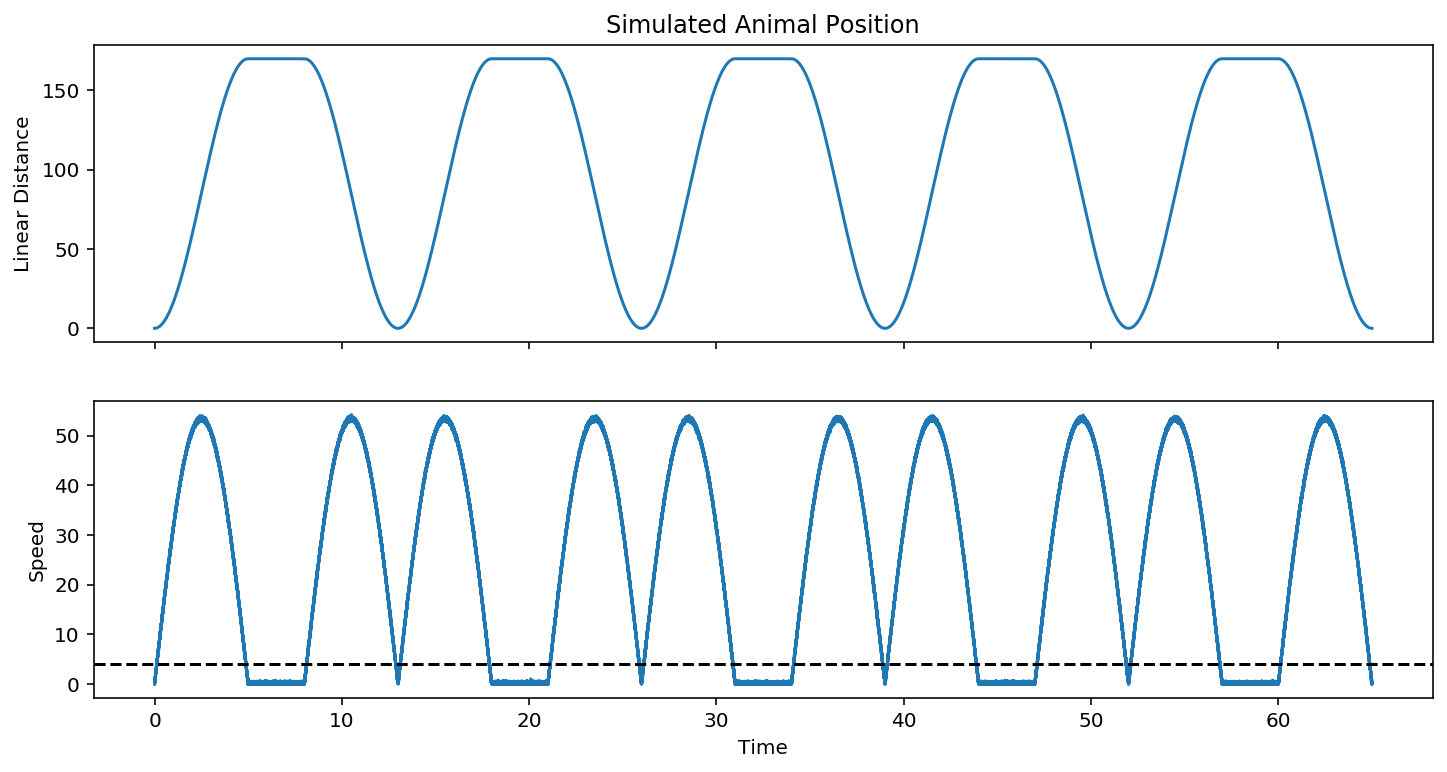

In [3]:
from replay_identification.simulate_spiking import simulate_time, simulate_linear_distance_with_pauses
from numpy.random import randn

track_height = 170
sampling_frequency = 1500
n_samples = sampling_frequency * 65

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
time = simulate_time(n_samples, sampling_frequency)
linear_distance = simulate_linear_distance_with_pauses(
    time, track_height, sampling_frequency=sampling_frequency, pause=3) + randn(*time.shape) * 1E-4
axes[0].plot(time, linear_distance);
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Simulated Animal Position')

speed = np.abs(np.diff(linear_distance) / np.diff(time))
speed = np.insert(speed, 0, 0.0)

axes[1].plot(time, speed)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Speed')
axes[1].axhline(4, linestyle='--', color='black');

### LFPs with ripples

The simulated animal pauses 5 times. Simulate 100 ms ripple band (200 Hz) events for the first 3 pauses.

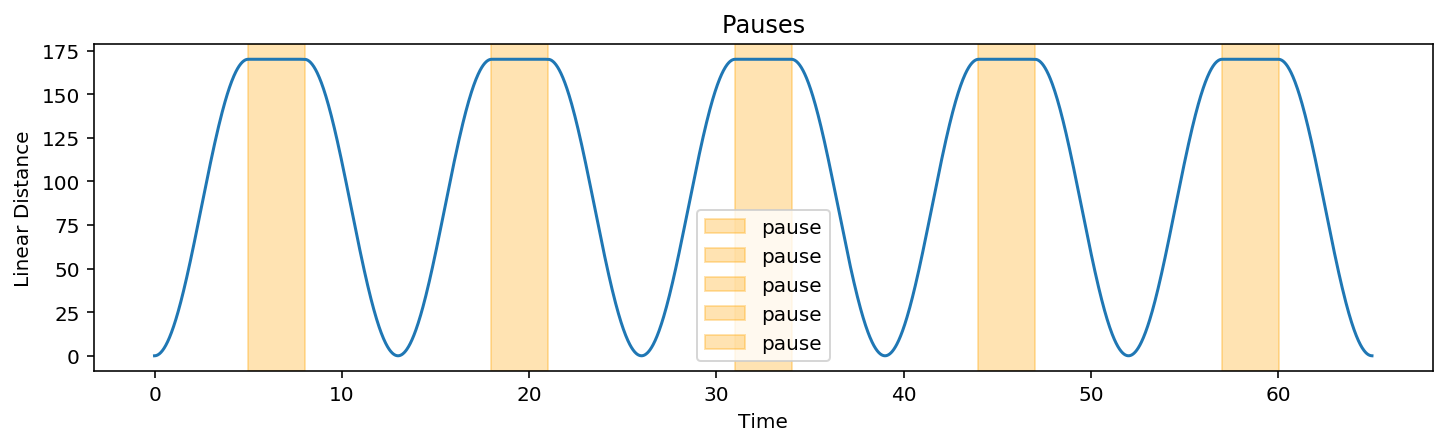

In [4]:
pause_ind = np.nonzero(np.diff(np.isclose(linear_distance, track_height, atol=1E-5)))[0] + 1

pause_times = time[np.reshape(pause_ind, (-1, 2))]
pause_width = np.diff(pause_times)[0]

fig, axes = plt.subplots(1, 1, figsize=(12, 3), sharex=True)
axes.plot(time, linear_distance);
axes.set_xlabel('Time')
axes.set_ylabel('Linear Distance')
axes.set_title('Pauses')

for start_time, end_time in pause_times:
    axes.axvspan(start_time, end_time, alpha=0.3, color='orange', label='pause')
    
plt.legend();

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)


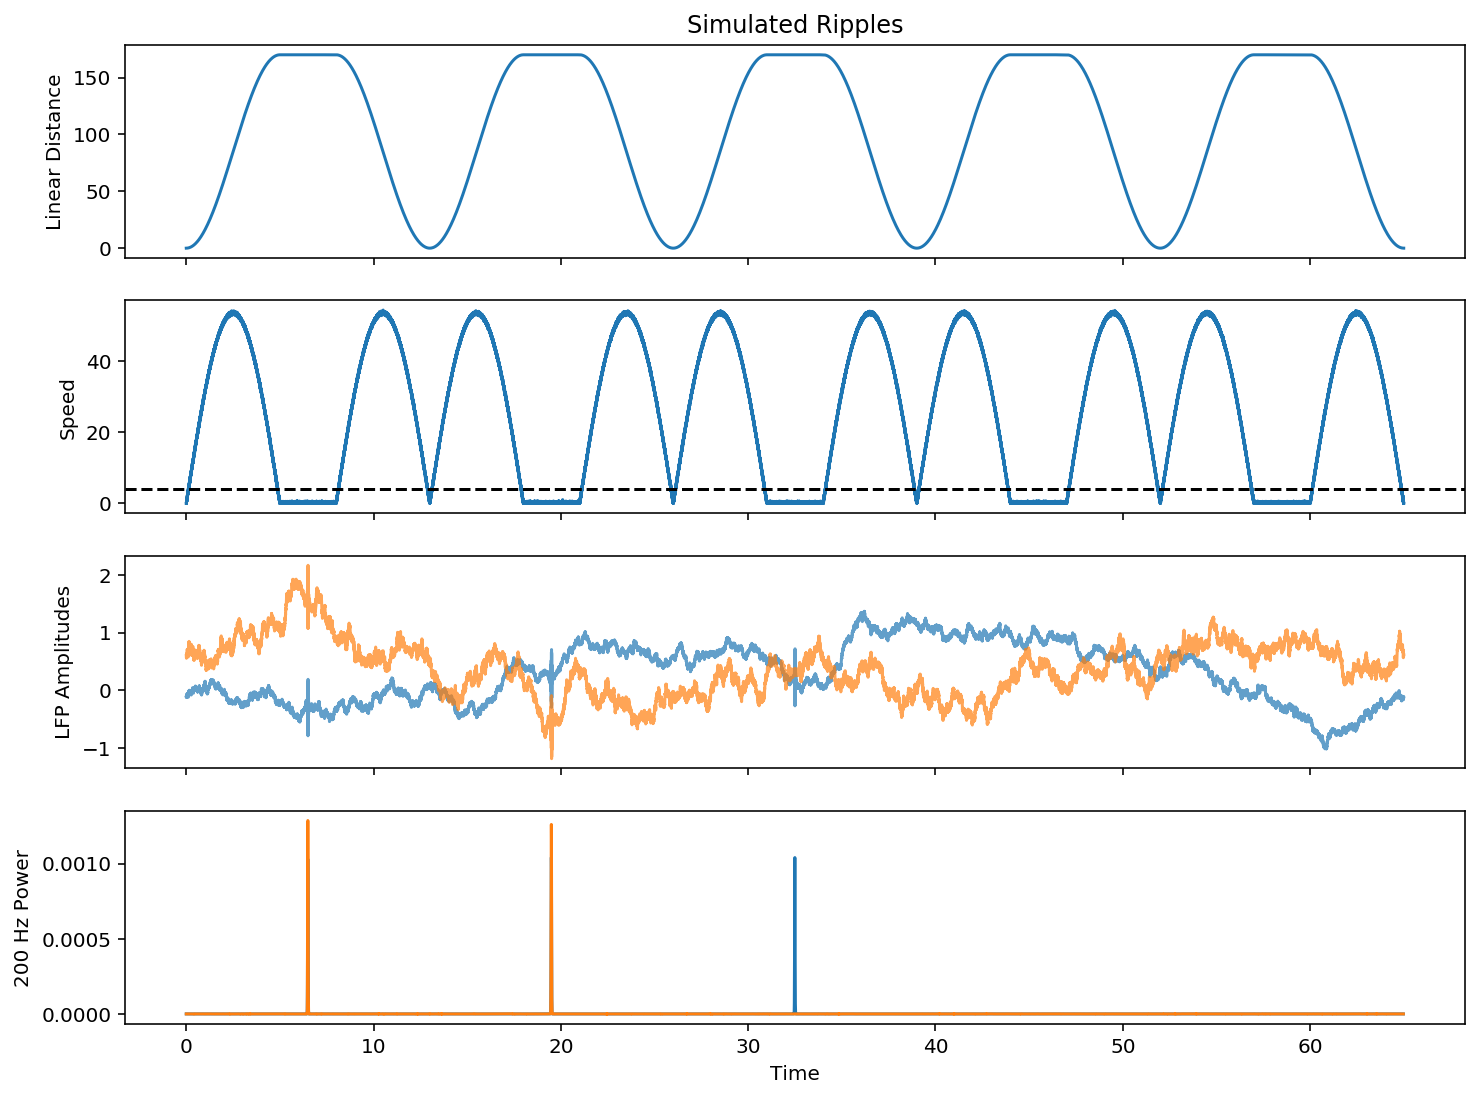

In [5]:
from replay_identification.simulate_LFP import simulate_LFP
from spectral_connectivity import Multitaper, Connectivity

ripple_duration = 0.100


lfps = np.stack((
    simulate_LFP(time, pause_times[:3, 0] + pause_width / 2, noise_amplitude=1.2,
                 ripple_amplitude=1, ripple_width=ripple_duration),
    simulate_LFP(time, pause_times[:2, 0] + pause_width / 2, noise_amplitude=1.2,
                 ripple_amplitude=1.1, ripple_width=ripple_duration)), axis=1
)


def estimate_ripple_band_power(lfps, sampling_frequency):
    """Estimates the 200 Hz power of each LFP.

    Parameters
    ----------
    lfps : ndarray, shape (n_time, n_signals)
    sampling_frequency : float

    Returns
    -------
    ripple_band_power : ndarray (n_time, n_signals)

    """
    n_time = lfps.shape[0]
    m = Multitaper(lfps, sampling_frequency=sampling_frequency,
                   time_halfbandwidth_product=1,
                   time_window_duration=0.020,
                   time_window_step=1 / sampling_frequency)
    c = Connectivity.from_multitaper(m)
    closest_200Hz_freq_ind = np.argmin(np.abs(c.frequencies - 200))
    power = c.power()[..., closest_200Hz_freq_ind, :].squeeze()
    n_power_time = power.shape[0]
    unobserved = np.full((n_time - n_power_time, *power.shape[1:]), np.nan)
    return np.concatenate((power, unobserved))

power = estimate_ripple_band_power(lfps, sampling_frequency)


fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
axes[0].plot(time, linear_distance);
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Simulated Ripples')

axes[1].plot(time, speed)

axes[1].set_ylabel('Speed')
axes[1].axhline(4, linestyle='--', color='black');
axes[2].plot(time, lfps, alpha=0.7, )
axes[2].set_ylabel('LFP Amplitudes')
axes[3].plot(time, power);
axes[3].set_ylabel('200 Hz Power')
axes[-1].set_xlabel('Time');

In [6]:
mid_ripple_time = pause_times[:3, 0] + pause_width / 2
ripple_times = (mid_ripple_time + np.array([-0.5, 0.5])[:, np.newaxis] * ripple_duration).T

Close up on the first simulated ripple to verify it worked

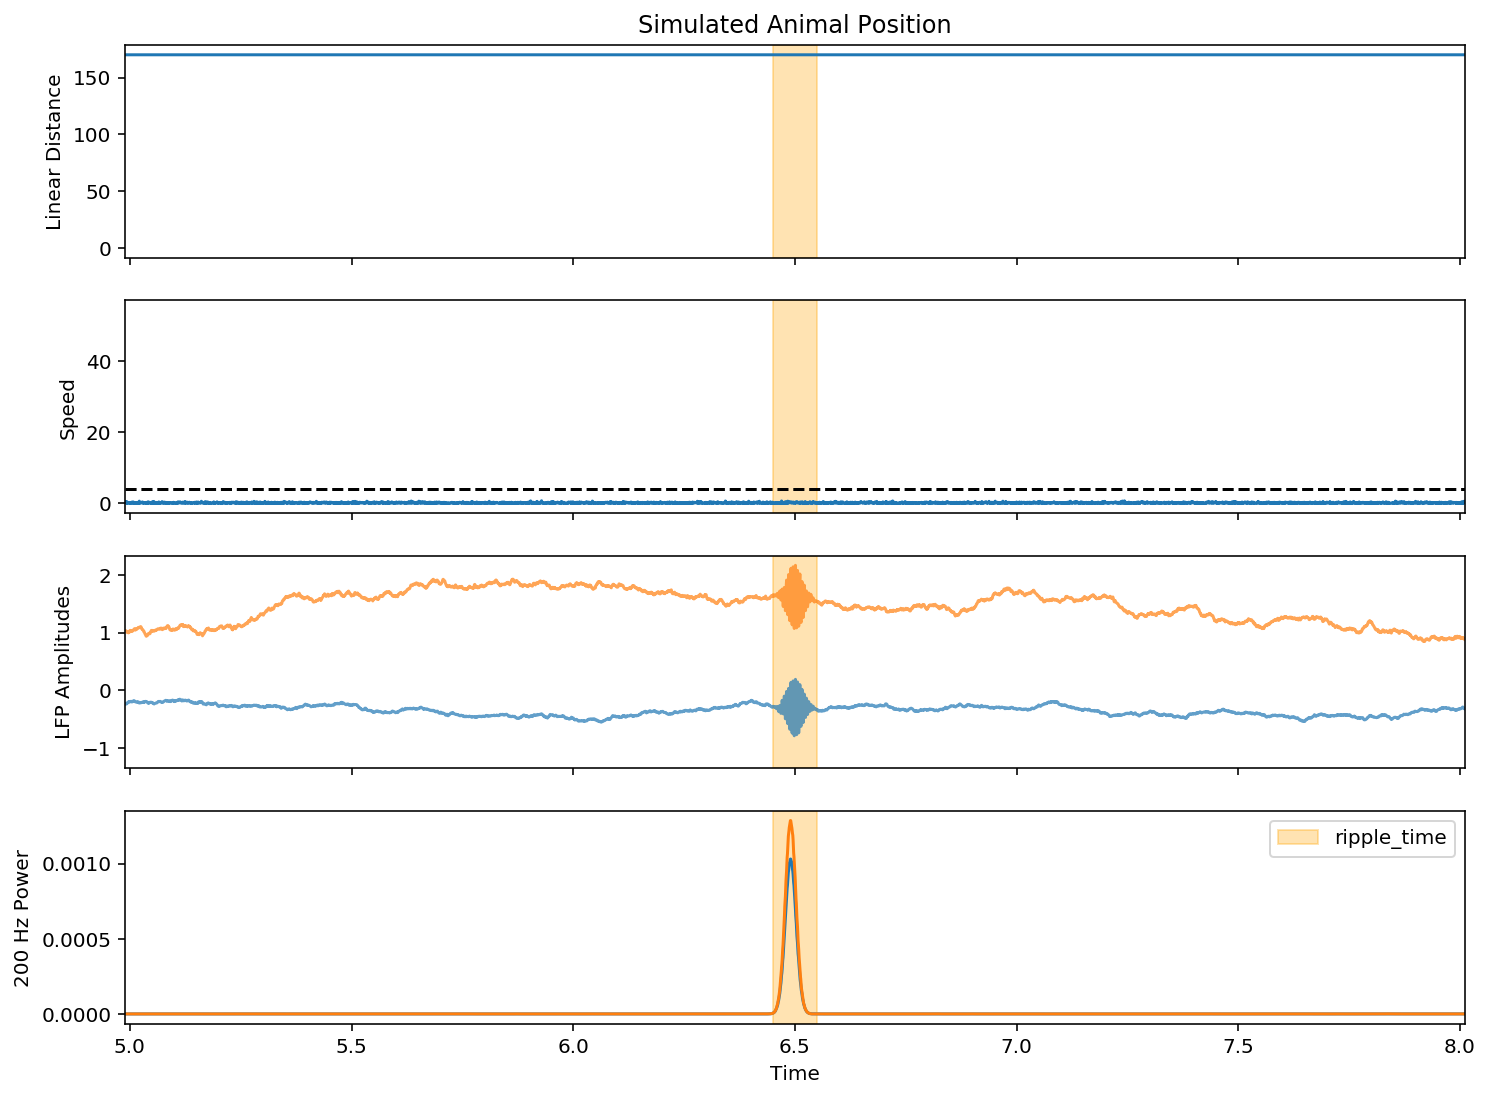

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
axes[0].plot(time, linear_distance);
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Simulated Animal Position')
axes[0].axvspan(ripple_times[0][0], ripple_times[0][1], color='orange', alpha=0.3)

axes[1].plot(time, speed)

axes[1].set_ylabel('Speed')
axes[1].axhline(4, linestyle='--', color='black')
axes[1].axvspan(ripple_times[0][0], ripple_times[0][1], color='orange', alpha=0.3)
axes[2].plot(time, lfps, alpha=0.7, )
axes[2].set_ylabel('LFP Amplitudes')
axes[2].axvspan(ripple_times[0][0], ripple_times[0][1], color='orange', alpha=0.3)
axes[3].plot(time, power);
axes[3].set_ylabel('200 Hz Power')
axes[3].axvspan(ripple_times[0][0], ripple_times[0][1], color='orange', alpha=0.3, label='ripple_time')
axes[-1].set_xlabel('Time');

plt.xlim((pause_times[0]))
plt.legend();

### Spikes with Place Fields

Simulate spikes with replay events on the 1st and 4th pauses

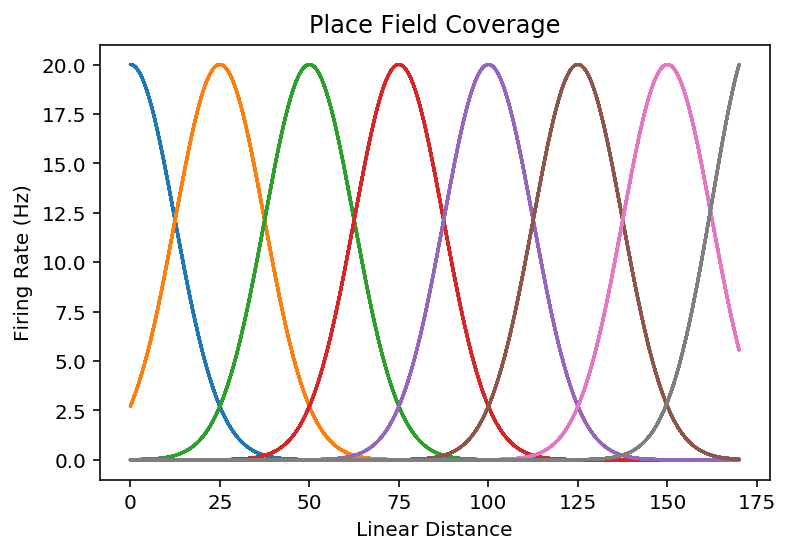

In [8]:
from replay_identification.simulate_spiking import create_place_field

place_field_support = np.arange(0, track_height)
place_field_means = np.arange(0, 200, 25)

place_fields = np.stack([create_place_field(
    place_field_mean, linear_distance, sampling_frequency)
                         for place_field_mean in place_field_means])
plt.plot(linear_distance, place_fields.T)
plt.xlabel('Linear Distance')
plt.ylabel('Firing Rate (Hz)')
plt.title('Place Field Coverage');

(97500, 8)


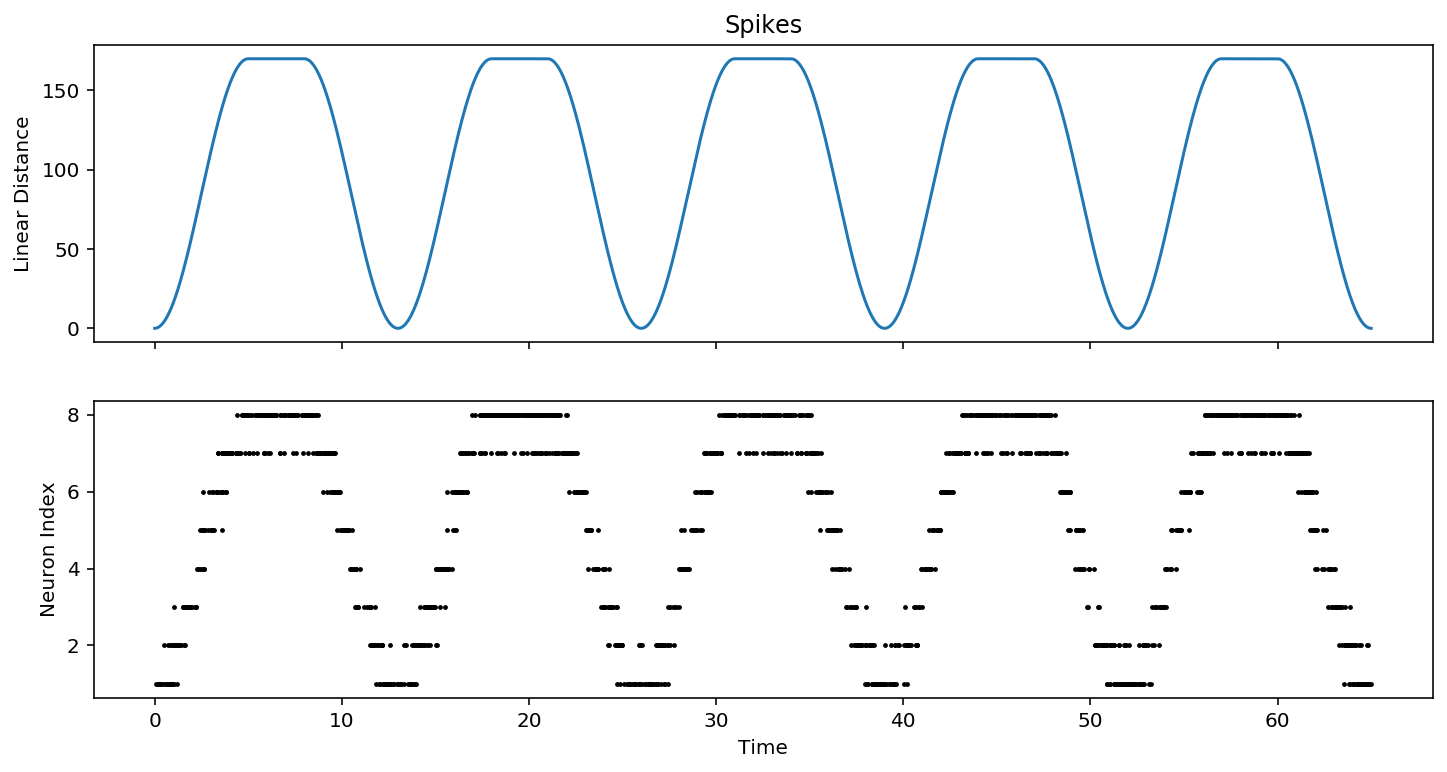

In [9]:
from replay_identification.simulate_spiking import simulate_poisson_spikes

spikes = simulate_poisson_spikes(place_fields, sampling_frequency).T
print(spikes.shape)

spike_ind, neuron_ind = np.nonzero(spikes)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(time, linear_distance)
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Spikes')
axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[1].set_ylabel('Neuron Index')
axes[-1].set_xlabel('Time');

#### Insert replay events in spiking for ripples \#1 and \#3

One in each direction (toward, away)

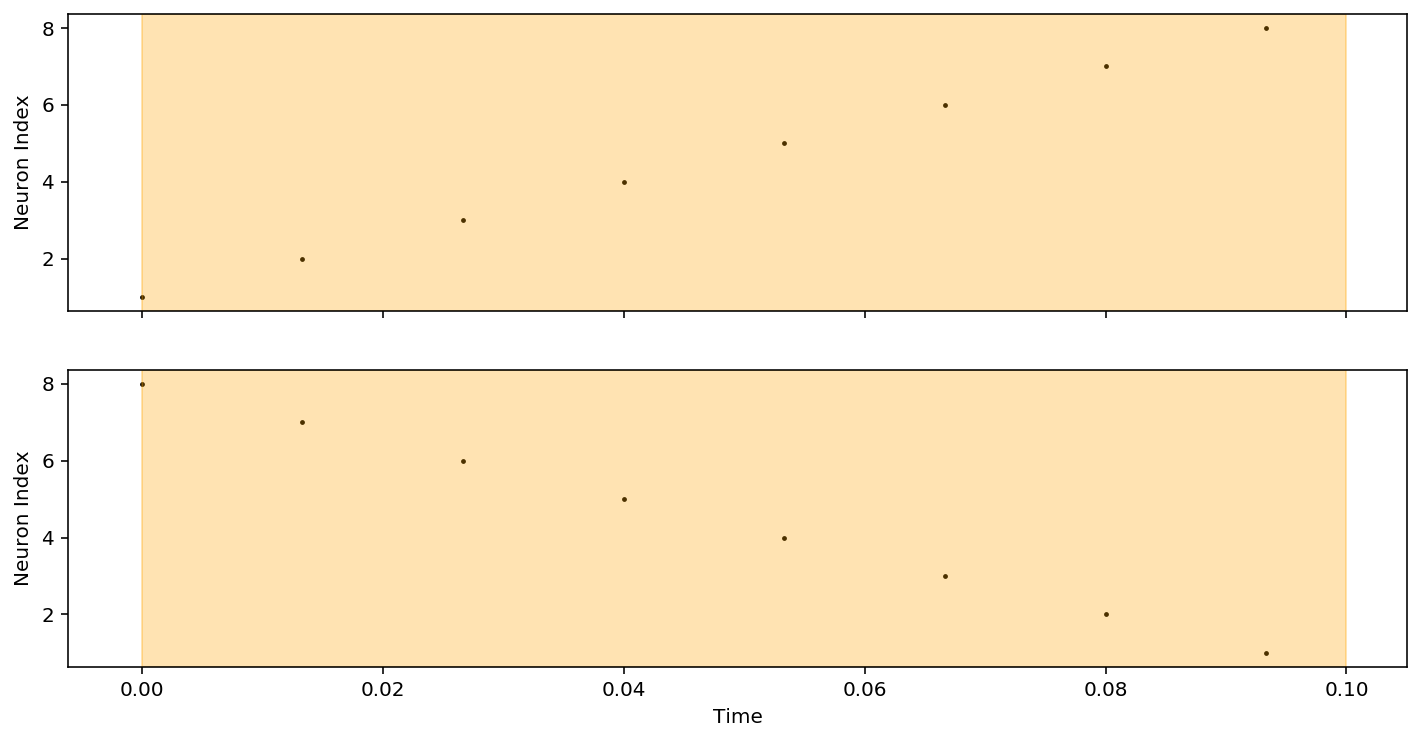

In [10]:
n_neurons = spikes.shape[1]
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
n_samples_between_spikes = 20
is_toward = np.array([0, 1], dtype=bool)

for ax, (start_time, end_time), flip in zip(axes, ripple_times[[0, -1]], is_toward):
    is_ripple_time = (time >= start_time) & (time <= end_time)
    ripple_ind = np.nonzero(is_ripple_time)[0]
    spikes[is_ripple_time] = 0
    neuron_order = np.flip(np.arange(n_neurons), axis=0) if flip else np.arange(n_neurons)
    replay_ind = (
        ripple_ind[0] +
        np.arange(0, n_neurons * n_samples_between_spikes, n_samples_between_spikes),
        neuron_order)
    spikes[replay_ind] = 1
    
    spike_ind, neuron_ind = np.nonzero(spikes[is_ripple_time])
    ax.scatter(spike_ind / sampling_frequency, neuron_ind + 1, color='black', s=2)
    ax.set_ylabel('Neuron Index')
    ax.axvspan(0, ripple_duration, alpha=0.3, color='orange')
    
axes[-1].set_xlabel('Time');

### Multiunit

In [11]:
from replay_identification.simulate_multiunit import simulate_multiunit

mark_means = np.array([200, 125, 325, 275])
place_field_means = np.stack((np.arange(0, 200, 50),
                              np.arange(25, 200, 50)))

multiunit = np.stack(
    [simulate_multiunit(place_field_means[0], mark_means, linear_distance, sampling_frequency),
     simulate_multiunit(place_field_means[1], mark_means, linear_distance, sampling_frequency),
    ], axis=-1)

/Users/edeno/Documents/GitHub/replay_identification/replay_identification/simulate_multiunit.py:45: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(unit, axis=0), axis=0)


In [12]:
n_units = multiunit.shape[1]

n_samples_between_spikes = 40
is_toward = np.array([0, 1], dtype=bool)

tetrode_ind = np.meshgrid(np.arange(multiunit.shape[1]), np.arange(multiunit.shape[2]))[1].flatten(order='F')
mean_order = np.stack((mark_means, mark_means)).flatten(order='F')

for start_time, end_time in ripple_times[[1]]:
    is_ripple_time = (time >= start_time) & (time <= end_time)
    clear_ind = (time >= start_time - 0.200) & (time <= end_time + 0.200)
    ripple_ind = np.nonzero(is_ripple_time)[0]
    multiunit[clear_ind] = np.nan
    time_ind = (ripple_ind[0] +
                np.arange(0, 2 * n_units * n_samples_between_spikes, n_samples_between_spikes))
    multiunit[time_ind, :, tetrode_ind] = mean_order[:, np.newaxis]

### Training Signal Indicator

/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


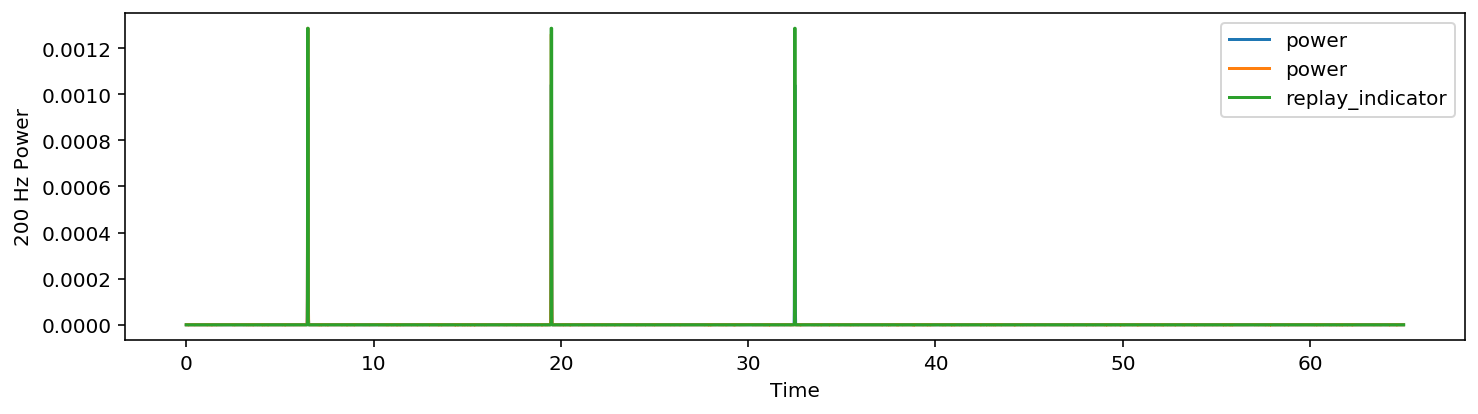

In [13]:
is_replay = np.any(power > 0.0004, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(time, power, label='power');
ax.plot(time, is_replay * np.nanmax(power), label='replay_indicator', zorder=100)
ax.set_ylabel('200 Hz Power')
ax.set_xlabel('Time')
plt.legend();

## Decoder Scenarios

In [14]:
from replay_identification import ReplayDetector
from sklearn.neighbors import KernelDensity

r = ReplayDetector(replay_speed=1, movement_var=4.0, place_bin_size=0.5, spike_model_knot_spacing=15,
                   spike_model_penalty=0.5, movement_state_transition_type='random_walk')
r.fit(is_replay, speed, linear_distance, power, spikes, multiunit)

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting multiunit model...


INFO:replay_identification.decoders:Fitting replay movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


ReplayDetector(infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=4.0,
               multiunit_density_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               multiunit_model_kwargs=...array([24., 24., 24., 24.,  6.])},
               multiunit_occupancy_kwargs={'bandwidth': array([6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=0.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=15,
               spike_model_penalty=0.5)

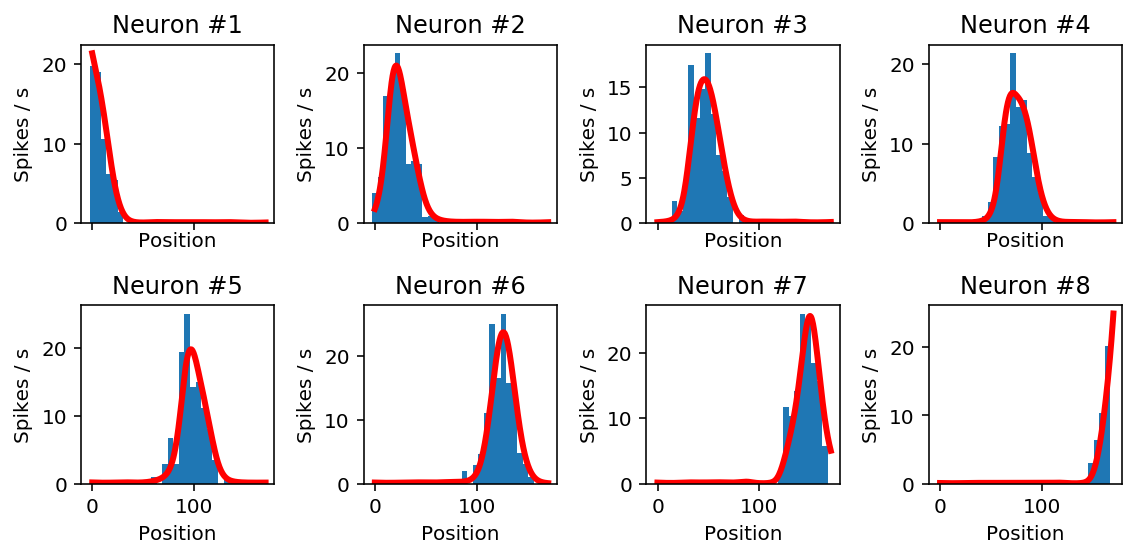

In [15]:
axes = r.plot_spikes(spikes, linear_distance, is_replay, sampling_frequency=sampling_frequency,
                     col_wrap=4)
r.plot_fitted_place_fields(sampling_frequency=sampling_frequency, axes=axes)

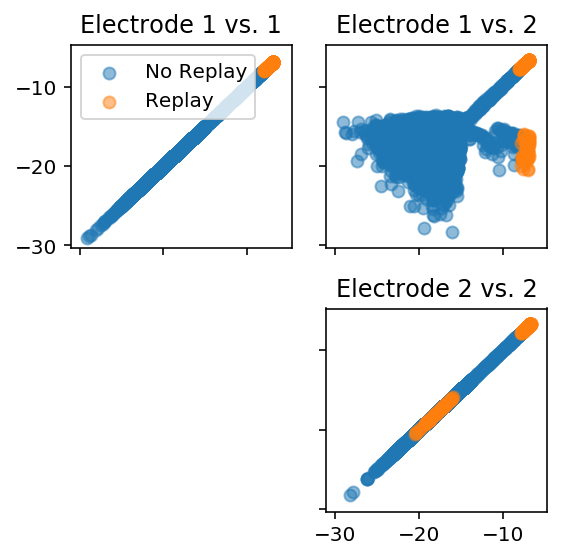

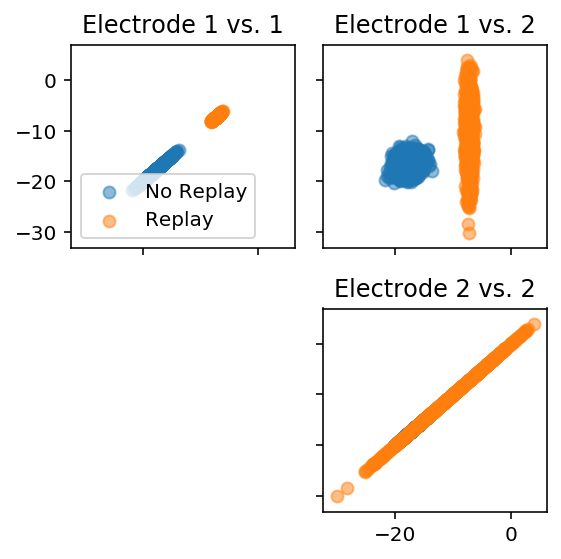

In [16]:
r.plot_lfp_power(power, is_replay)
r.plot_fitted_lfp_power_model()

In [17]:
# r.plot_multiunit(multiunit, linear_distance, is_replay)
# plt.suptitle('Actual multiunit data')
# r.plot_fitted_multiunit_model();
# plt.suptitle('Samples from fitted model', y=1.05)
# r.plot_fitted_multiunit_model(sampling_frequency, mark_edges=np.linspace(0, 400, 50), is_histogram=True);
# plt.suptitle('Samples from fitted model, histogrammed', y=1.05);

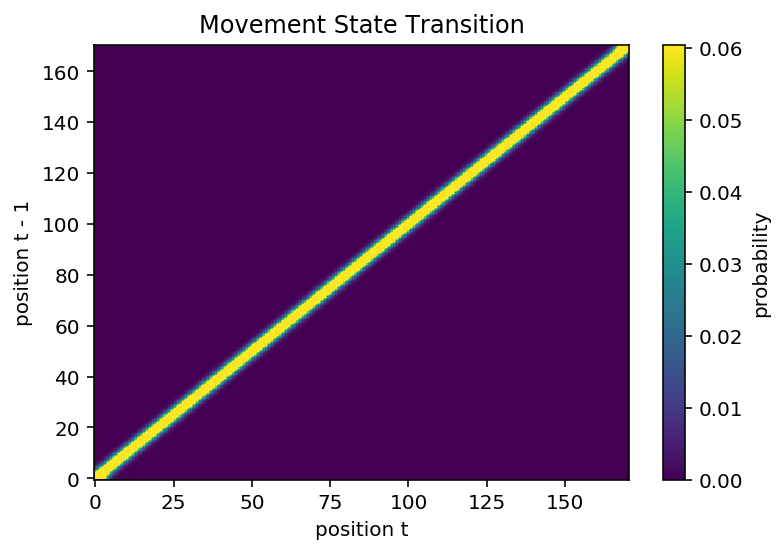

In [18]:
r.plot_movement_state_transition()

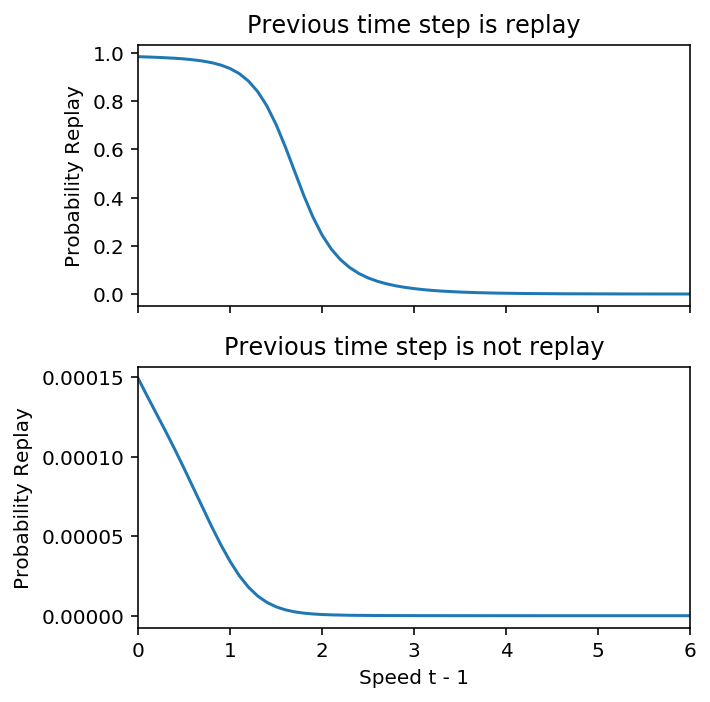

In [19]:
r.plot_replay_state_transition()
plt.xlim((0, 6));

### Spikes, LFP Power, and Speed

INFO:replay_identification.decoders:Predicting speed likelihood...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


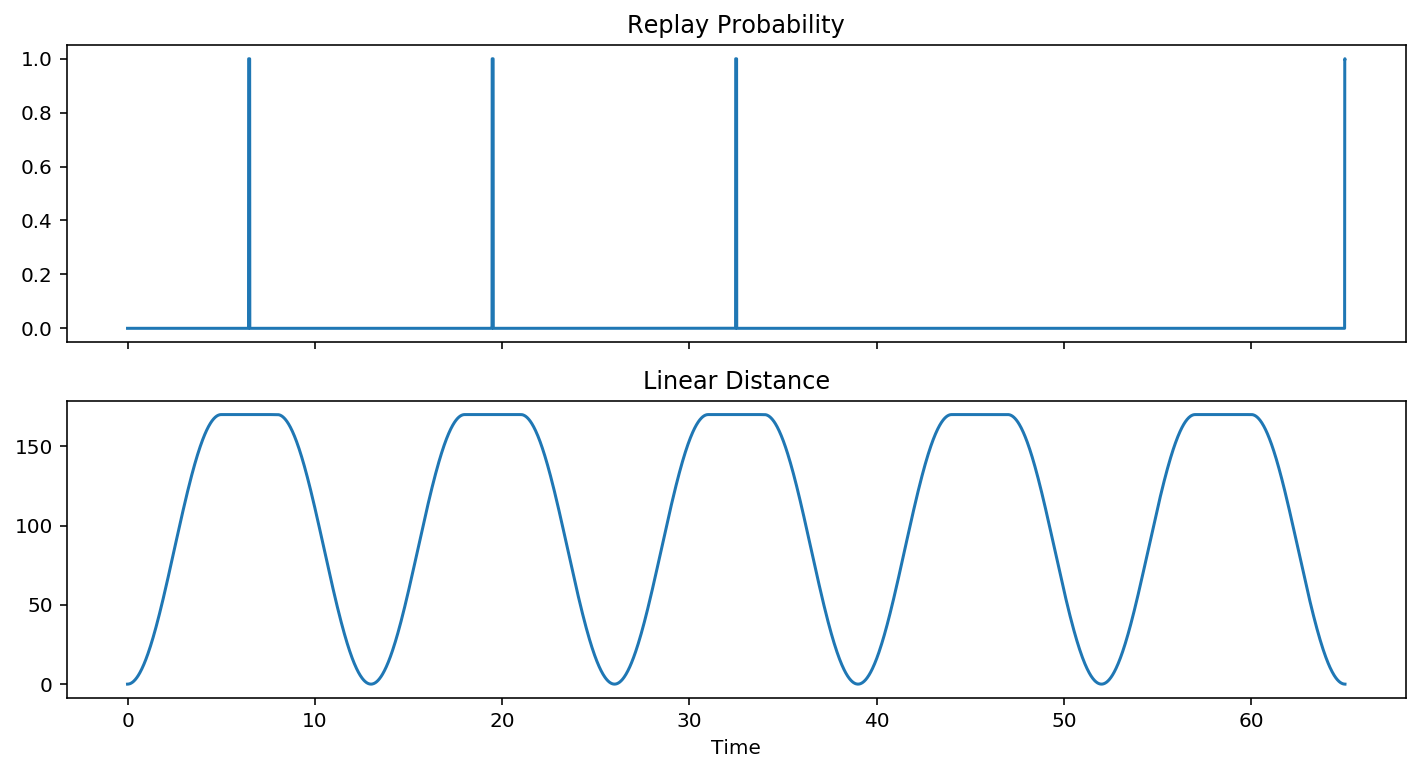

In [20]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time,
    use_likelihoods=['spikes', 'lfp_power', 'speed'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

### Spikes Only

INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


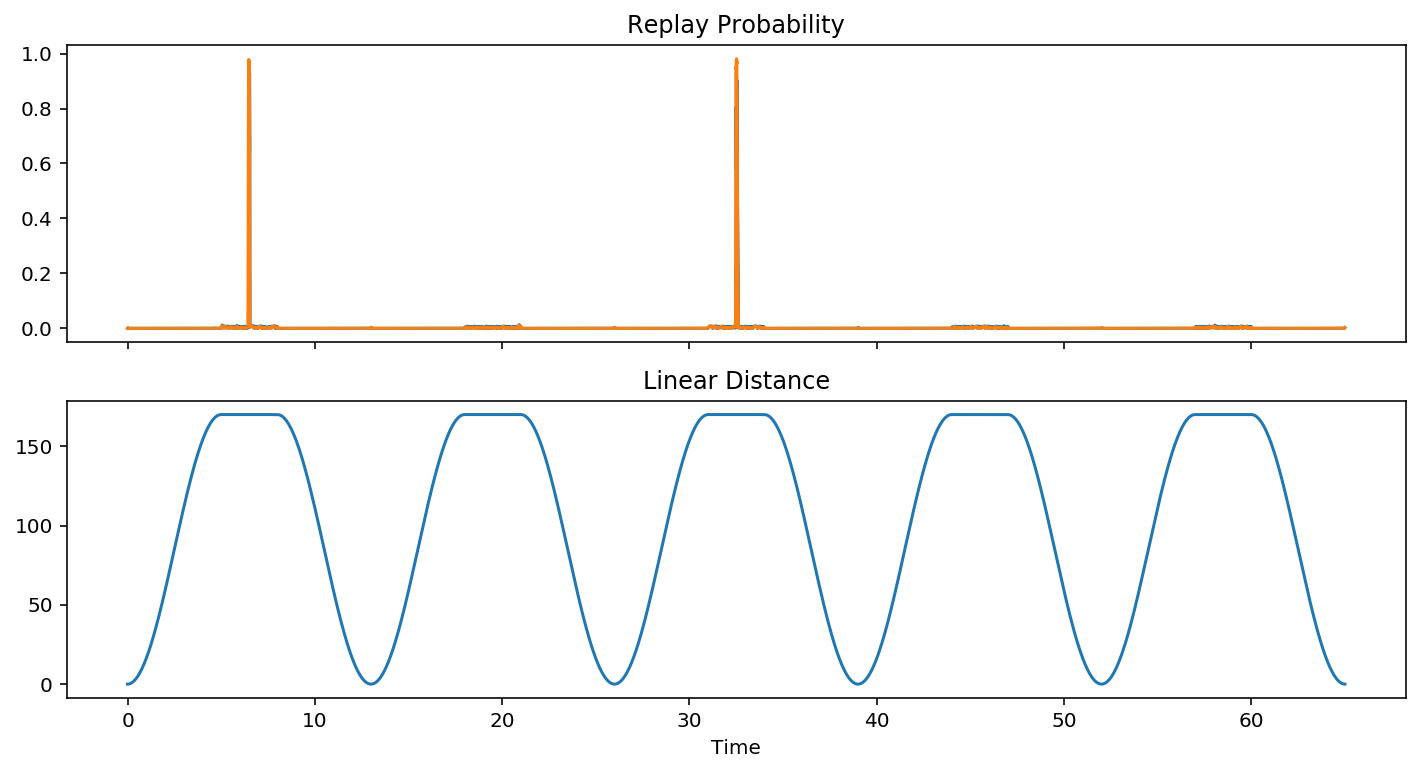

In [21]:
from replay_identification import ReplayDetector
from sklearn.neighbors import KernelDensity

filter_results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['spikes'],
    use_smoother=False)

smoother_results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['spikes'],
    use_smoother=True)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(filter_results.time, filter_results.replay_probability)
axes[0].plot(smoother_results.time, smoother_results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

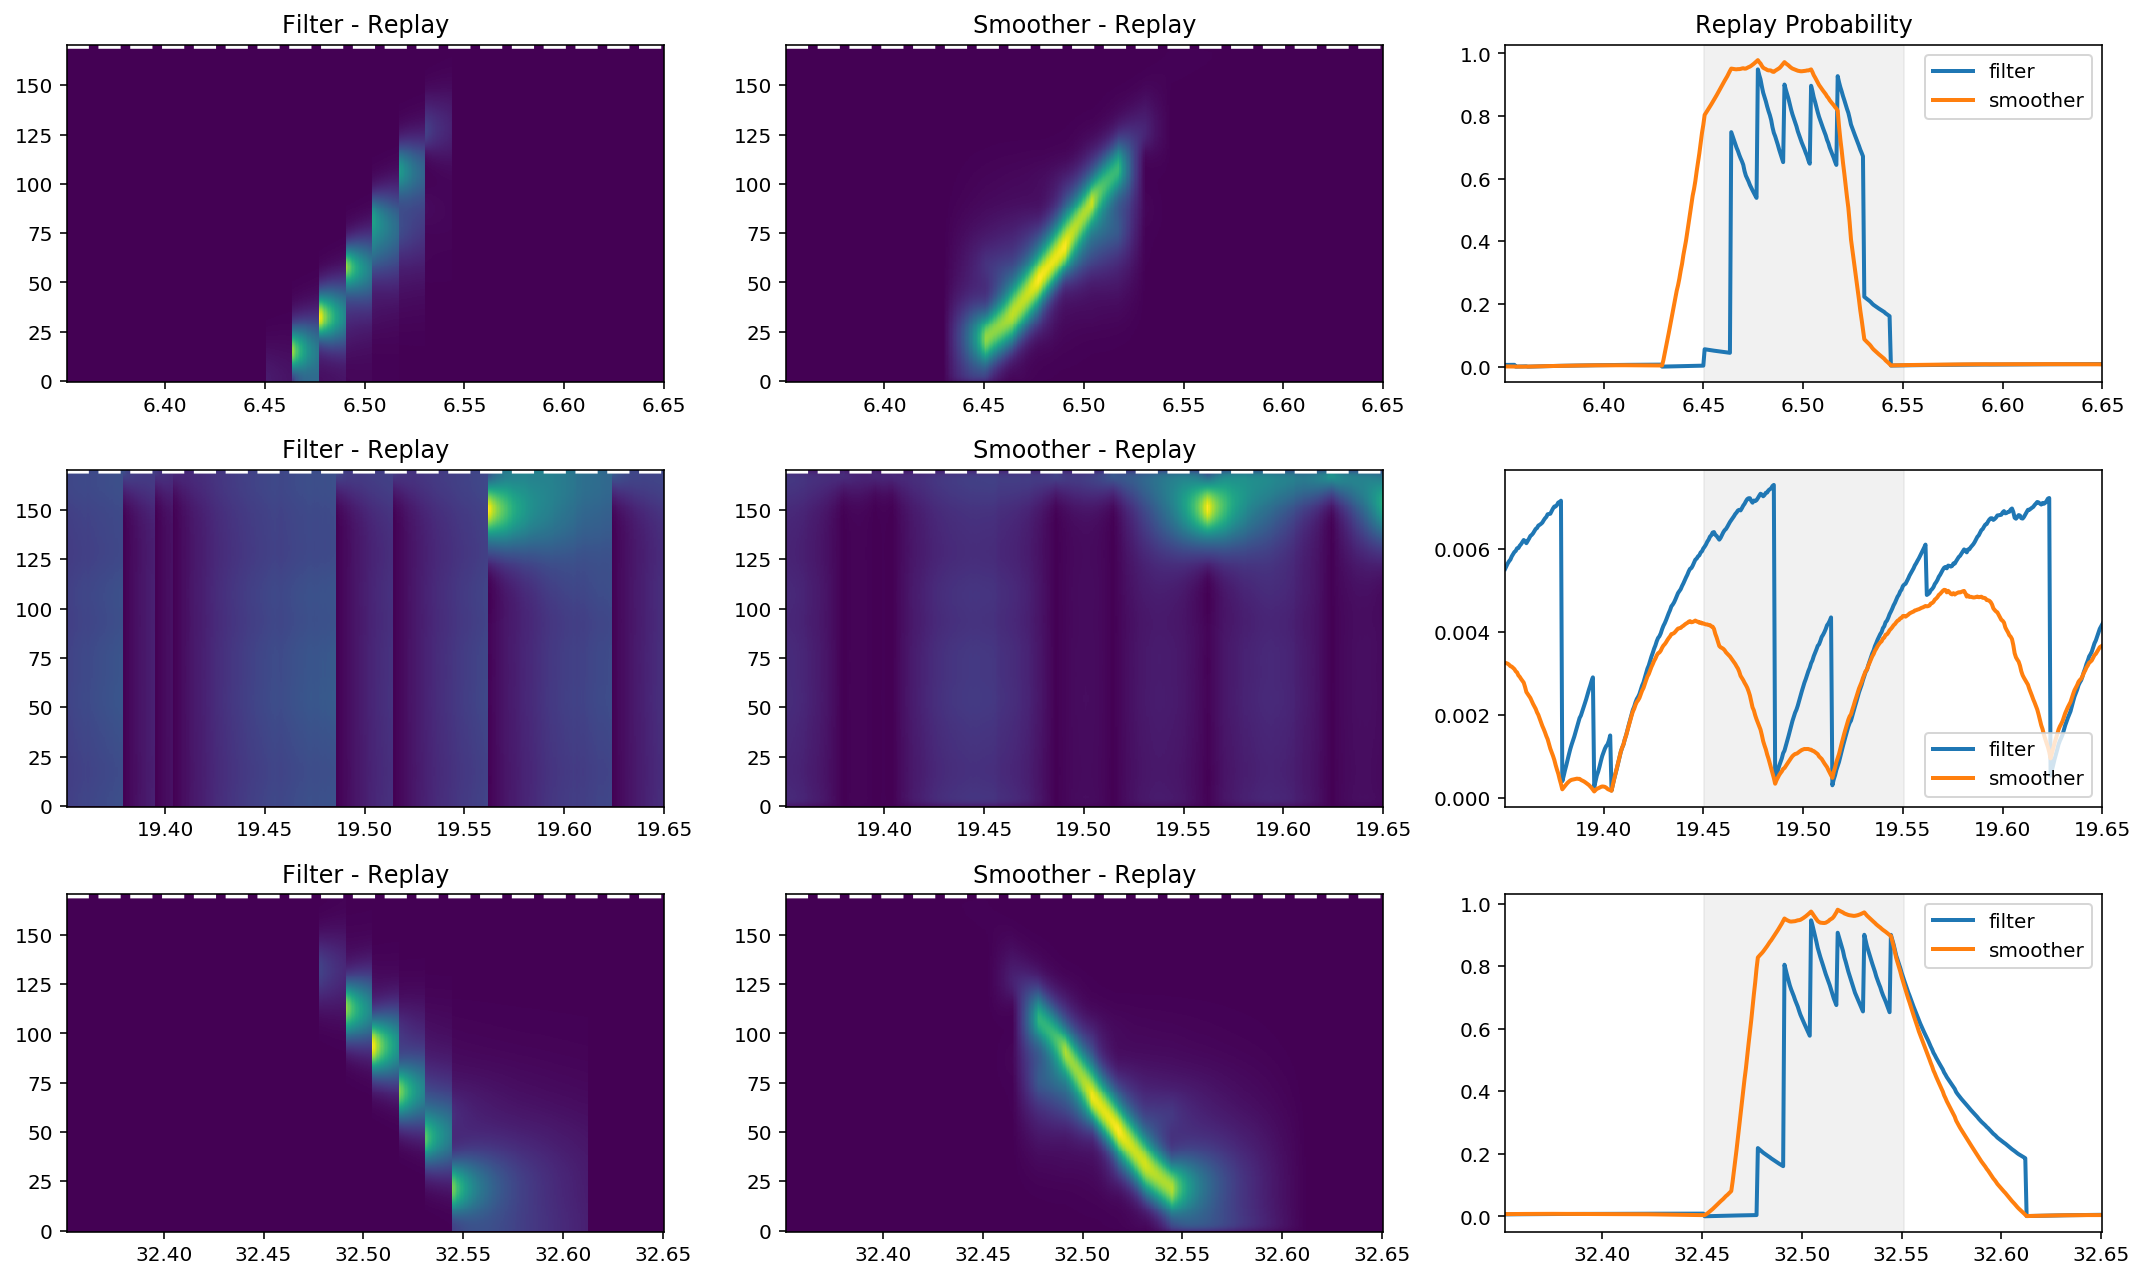

In [22]:
n_ripples = len(ripple_times)
fig, axes = plt.subplots(n_ripples, 3, figsize=(15, n_ripples * 3))
filter_posterior = filter_results.causal_posterior.values
smoother_posterior = smoother_results.acausal_posterior.values
filter_probability = filter_results.replay_probability.values
smoother_probability = smoother_results.replay_probability.values
offset = 0.100
place_bin_edges = r.place_bin_edges_

for ax, (start_time, end_time) in zip(axes, ripple_times):
    start_time -= offset
    end_time += offset
    start_ind, end_ind = np.searchsorted(time, [start_time, end_time])
    t, p = np.meshgrid(time[start_ind:end_ind], place_bin_edges)
    xlim = (time[start_ind:end_ind].min(), time[start_ind:end_ind].max())
    
    ax[0].pcolormesh(t, p, filter_posterior[start_ind:end_ind, 1, :].T);
    ax[0].plot(time[start_ind:end_ind], linear_distance[start_ind:end_ind],
               linestyle='--', color='white', linewidth=3)
    
    ax[0].set_title('Filter - Replay');
    ax[0].set_xlim(xlim)
    
    ax[1].pcolormesh(t, p, smoother_posterior[start_ind:end_ind, 1, :].T);
    ax[1].plot(time[start_ind:end_ind], linear_distance[start_ind:end_ind],
               linestyle='--', color='white', linewidth=3)
    ax[1].set_title('Smoother - Replay');
    ax[1].set_xlim(xlim)
    
    ax[2].plot(time[start_ind:end_ind], filter_probability[start_ind:end_ind],
               label='filter', linewidth=2);
    ax[2].plot(time[start_ind:end_ind], smoother_probability[start_ind:end_ind],
               label='smoother', linewidth=2);
    ax[2].axvspan(start_time + offset, end_time - offset, color='lightgrey', alpha=0.3)
    ax[2].legend()
    ax[2].set_xlim(xlim)

axes[0, -1].set_title('Replay Probability')
plt.tight_layout()

### LFP Power Only

INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...


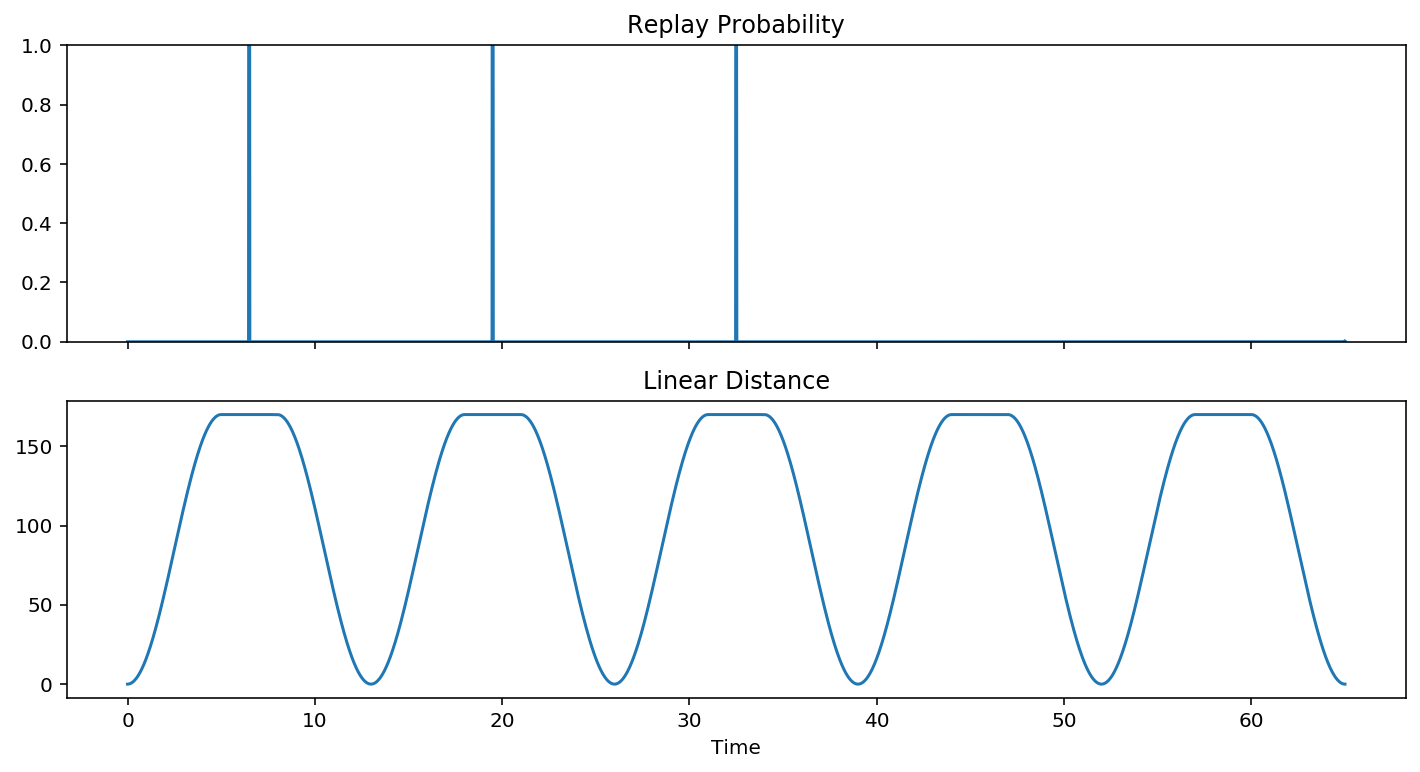

In [23]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['lfp_power'],
    use_smoother=False)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[0].set_ylim((0, 1))
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

## Speed Only

INFO:replay_identification.decoders:Predicting speed likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


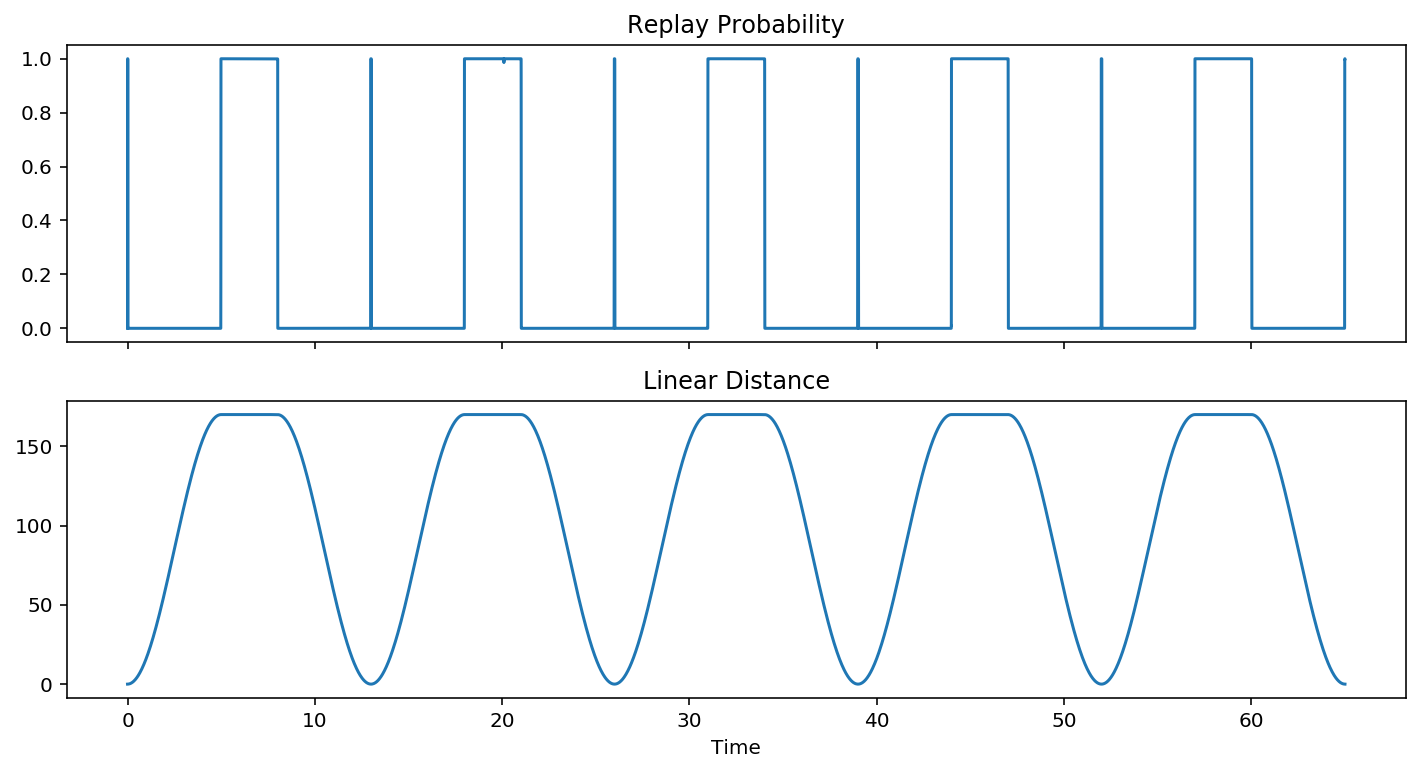

In [24]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['speed'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

### Speed and Spikes

INFO:replay_identification.decoders:Predicting speed likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


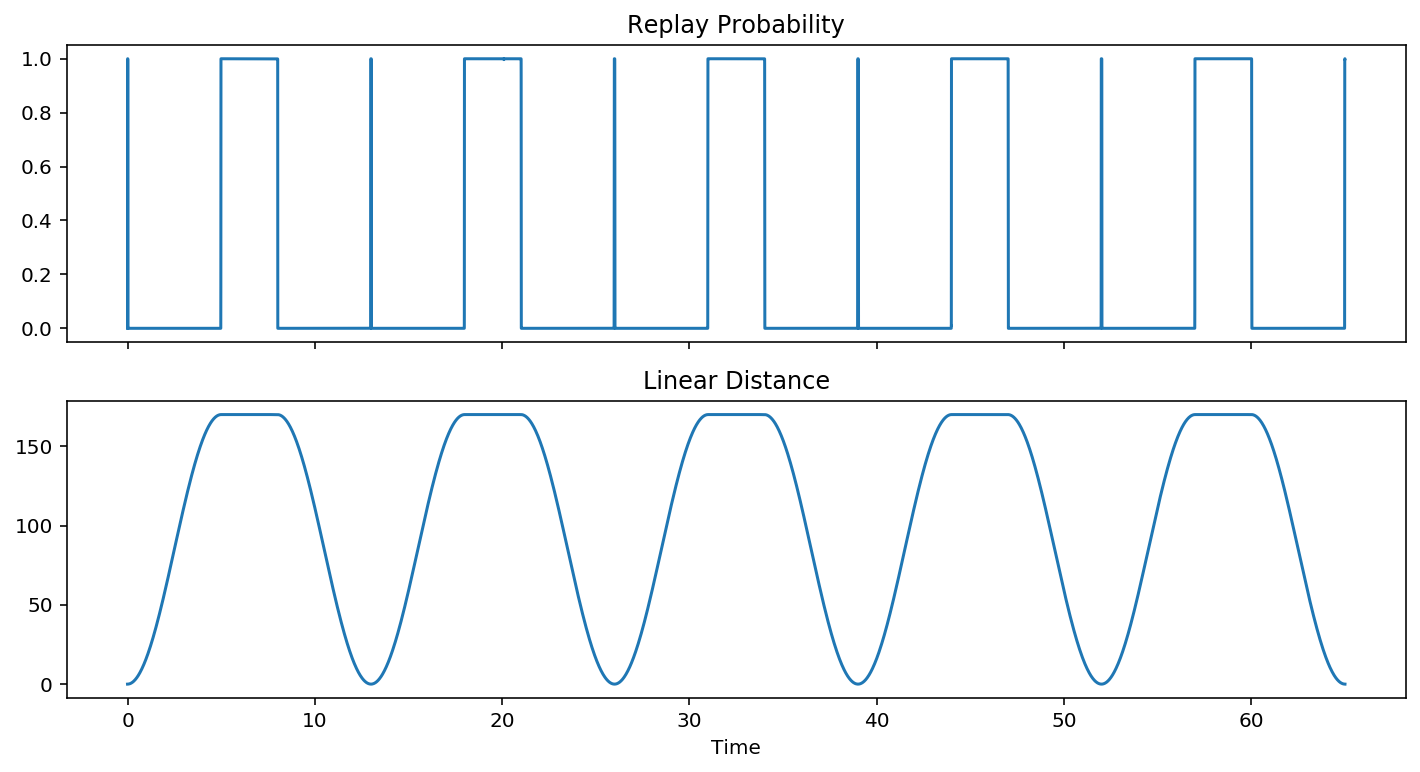

In [25]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['speed', 'spikes'],
    use_smoother=True)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

### Spikes and LFP

INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


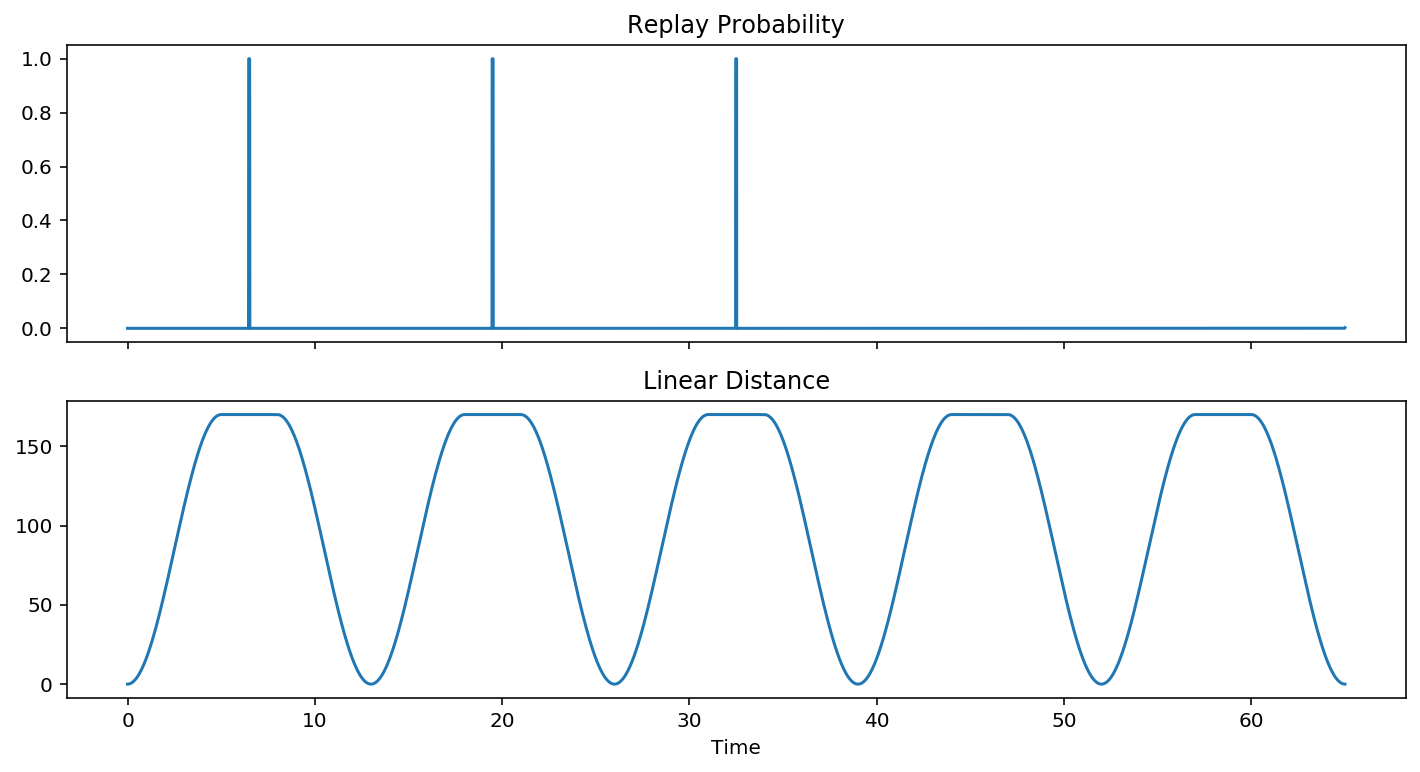

In [26]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['spikes', 'lfp_power'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

### Speed and LFP

INFO:replay_identification.decoders:Predicting speed likelihood...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


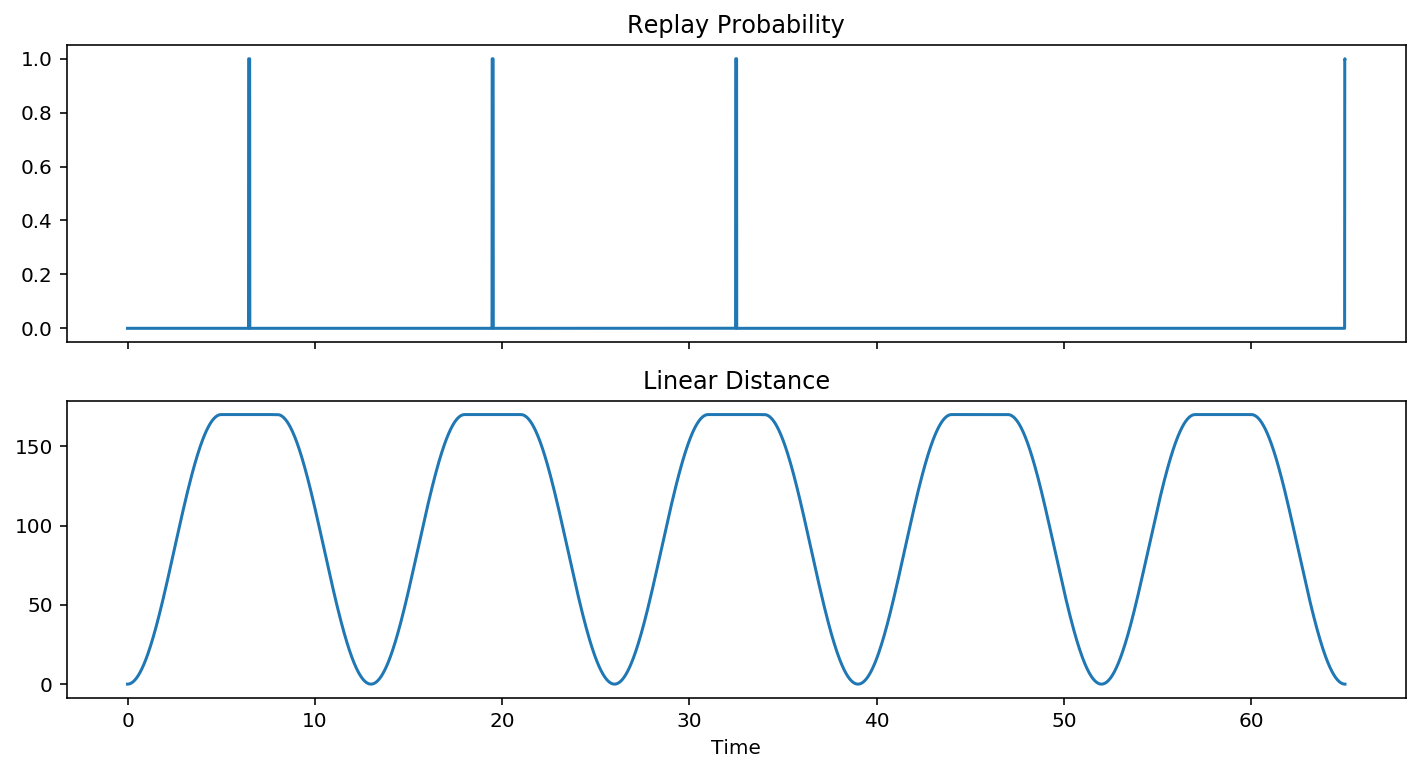

In [27]:
results = r.predict(
    speed, linear_distance, power, spikes, time=time, use_likelihoods=['speed', 'lfp_power'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

## Multiunit Only

INFO:replay_identification.decoders:Predicting multiunit likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Predicting multiunit likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


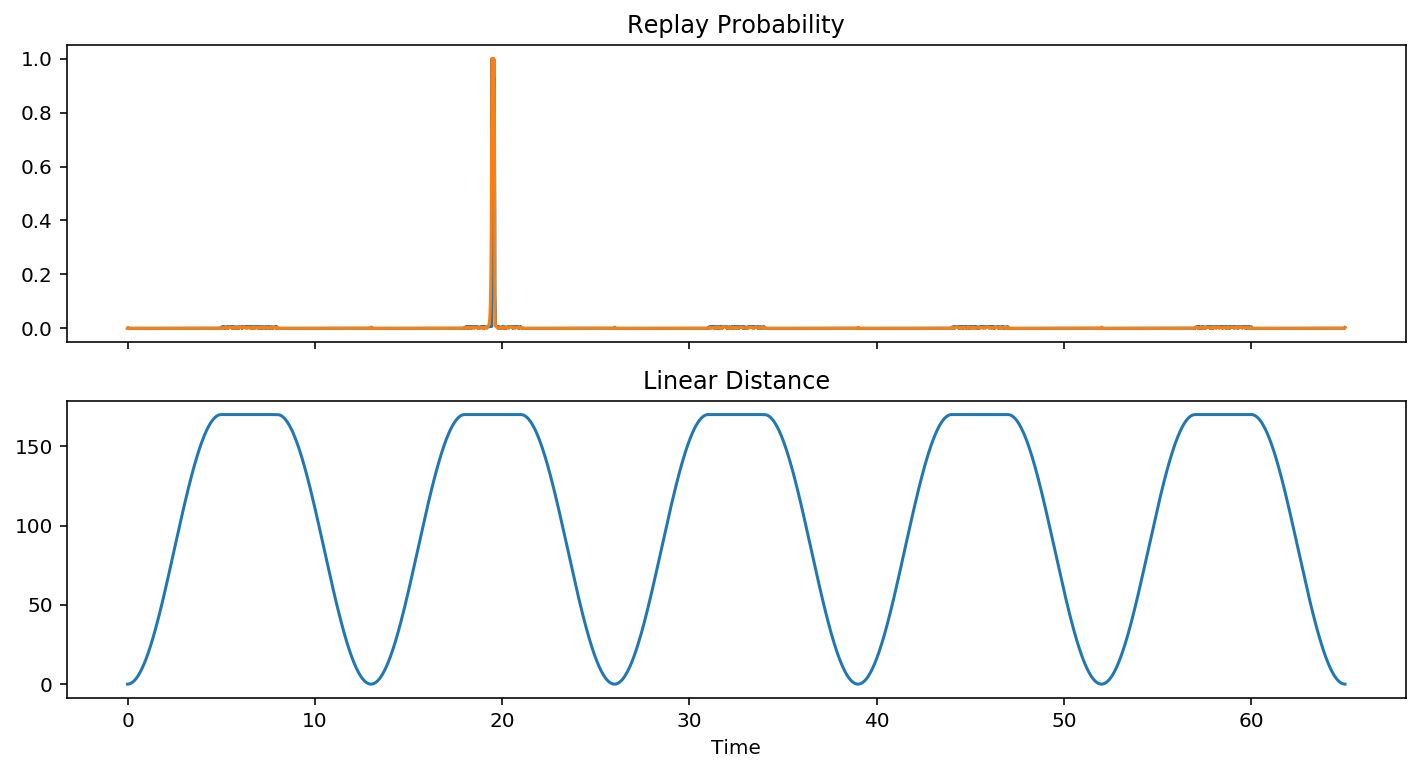

In [28]:
from replay_identification import ReplayDetector

filter_results = r.predict(
    speed, linear_distance, power, multiunit=multiunit, time=time, use_likelihoods=['multiunit'],
    use_smoother=False)

smoother_results = r.predict(
    speed, linear_distance, power, multiunit=multiunit, time=time, use_likelihoods=['multiunit'],
    use_smoother=True)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axes[0].plot(filter_results.time, filter_results.replay_probability)
axes[0].plot(smoother_results.time, smoother_results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

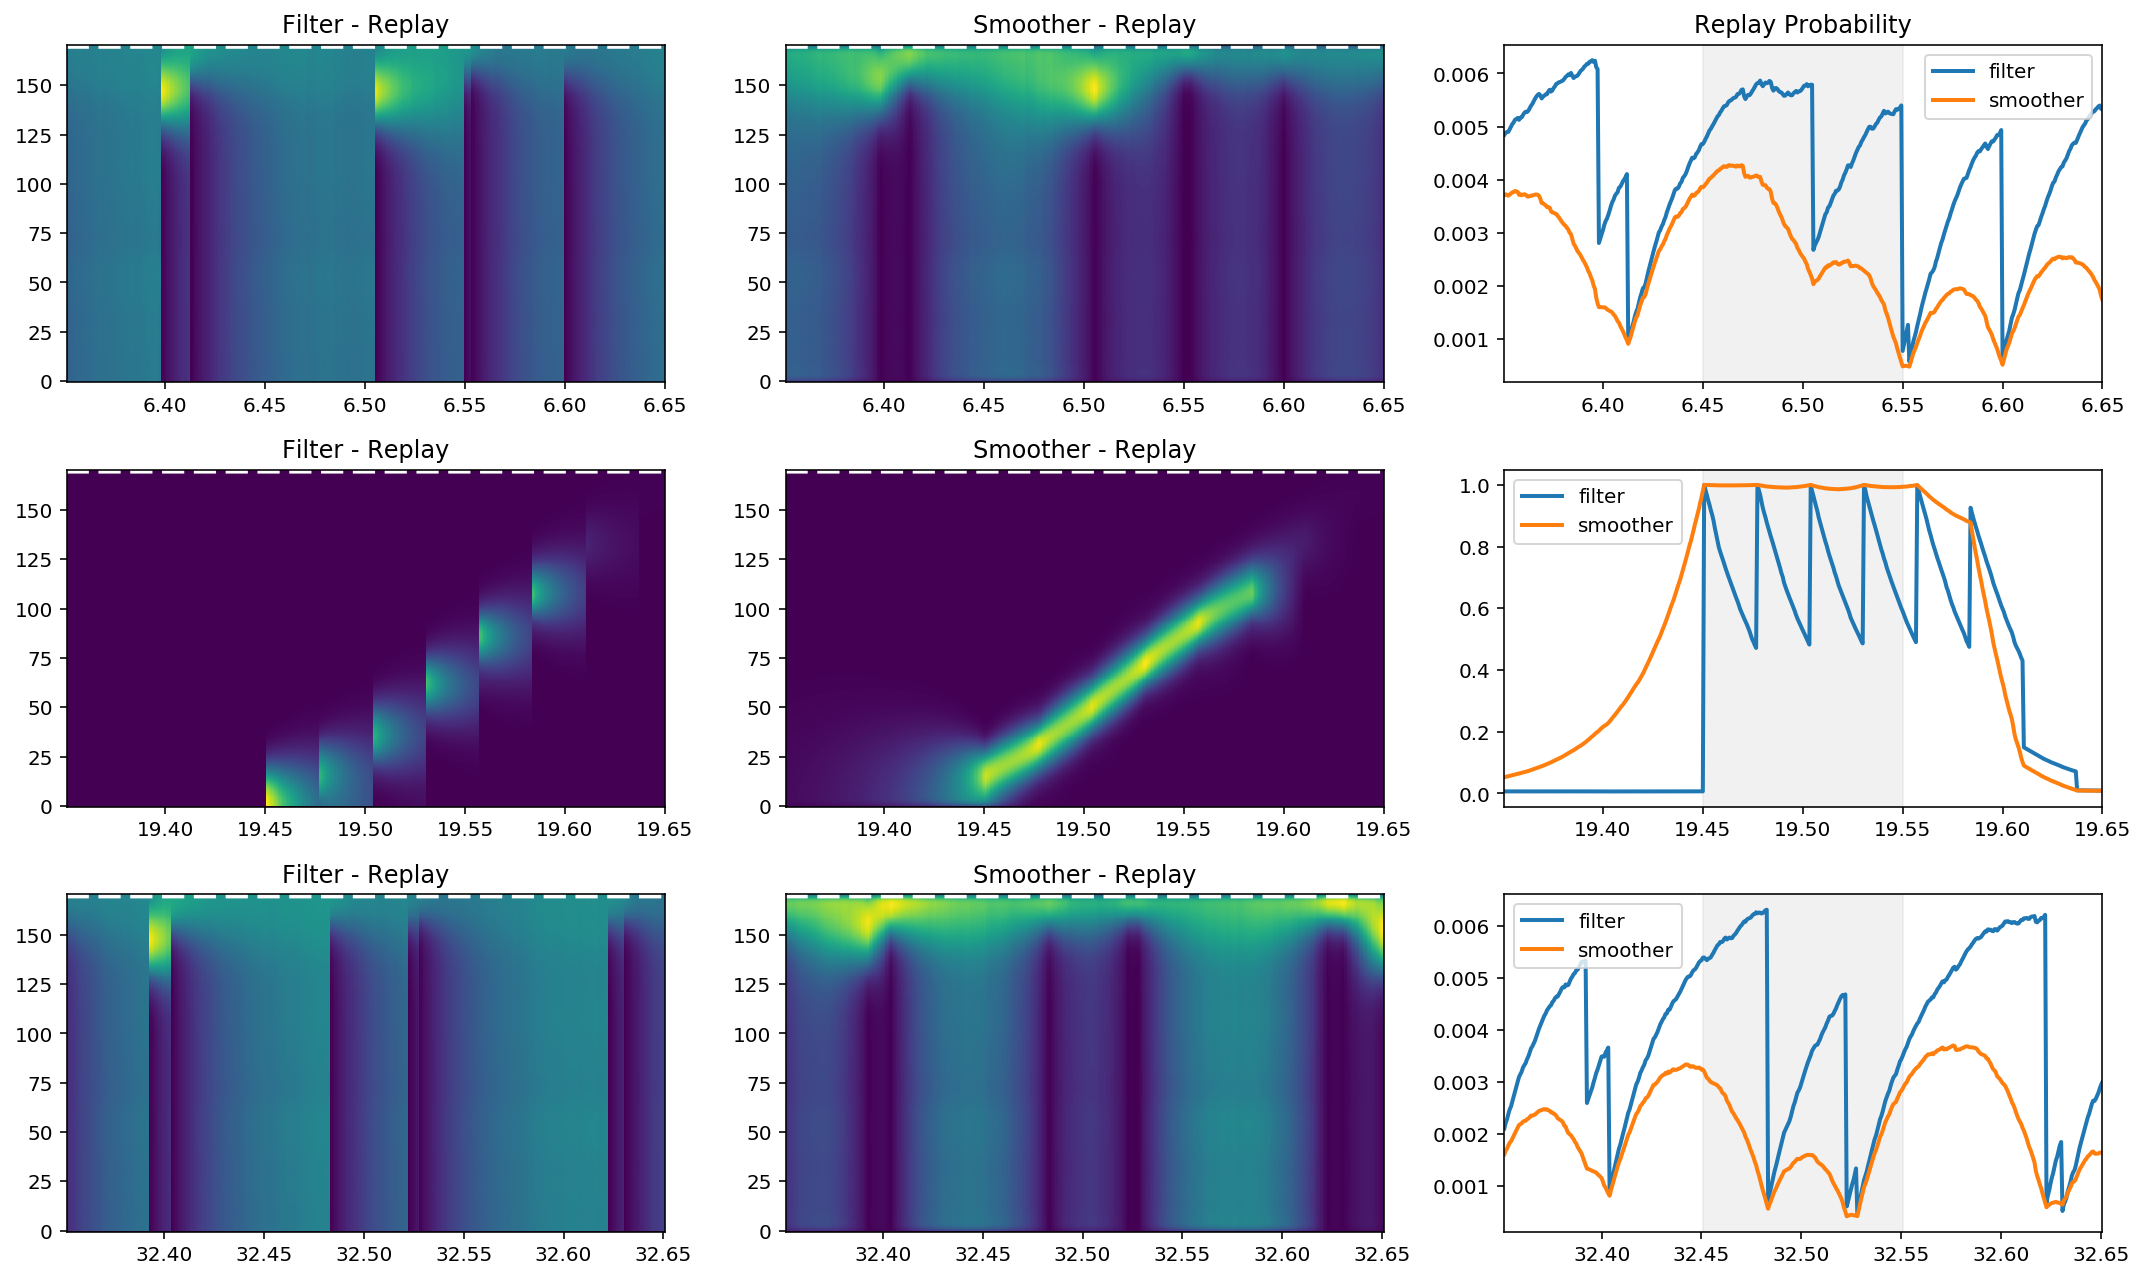

In [29]:
n_ripples = len(ripple_times)
fig, axes = plt.subplots(n_ripples, 3, figsize=(15, n_ripples * 3))
filter_posterior = filter_results.causal_posterior.values
smoother_posterior = smoother_results.acausal_posterior.values
filter_probability = filter_results.replay_probability.values
smoother_probability = smoother_results.replay_probability.values
offset = 0.100
place_bin_edges = r.place_bin_edges_

for ax, (start_time, end_time) in zip(axes, ripple_times):
    start_time -= offset
    end_time += offset
    start_ind, end_ind = np.searchsorted(time, [start_time, end_time])
    t, p = np.meshgrid(time[start_ind:end_ind], place_bin_edges)
    xlim = (time[start_ind:end_ind].min(), time[start_ind:end_ind].max())
    
    ax[0].pcolormesh(t, p, filter_posterior[start_ind:end_ind, 1, :].T);
    ax[0].plot(time[start_ind:end_ind], linear_distance[start_ind:end_ind],
               linestyle='--', color='white', linewidth=3)
    
    ax[0].set_title('Filter - Replay');
    ax[0].set_xlim(xlim)
    
    ax[1].pcolormesh(t, p, smoother_posterior[start_ind:end_ind, 1, :].T);
    ax[1].plot(time[start_ind:end_ind], linear_distance[start_ind:end_ind],
               linestyle='--', color='white', linewidth=3)
    ax[1].set_title('Smoother - Replay');
    ax[1].set_xlim(xlim)
    
    ax[2].plot(time[start_ind:end_ind], filter_probability[start_ind:end_ind],
               label='filter', linewidth=2);
    ax[2].plot(time[start_ind:end_ind], smoother_probability[start_ind:end_ind],
               label='smoother', linewidth=2);
    ax[2].axvspan(start_time + offset, end_time - offset, color='lightgrey', alpha=0.3)
    ax[2].legend()
    ax[2].set_xlim(xlim)

axes[0, -1].set_title('Replay Probability')
plt.tight_layout()